# UCLA Results Validation

This notebook is aimed at attemping to validate the results achieved by UCLA in their paper

In [1]:
import sys
sys.path.append("../")
sys.path.append("../../venv/lib/python3.6/site-packages/")

In [2]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
import h5py
from lib import transforms

/home/jesper/tmp/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading up the data

In [3]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImages(source="UCLA")
len(imgs)


11646

Get the labels

In [4]:
cols = ["name", "label"]
tag_cols = ["sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
split_tags = ['ucla-test', 'ucla-train']
imgs = imgs[cols + tag_cols + split_tags]
# indx_non_violence = imgs['label'].isnull()

imgs.loc[:,tag_cols] = imgs.loc[:,tag_cols].astype(int)
imgs = imgs.rename(columns={"label": "violence"})
# imgs = imgs[~imgs["violence"].isna()]

### Pre-processing

In [6]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
# imgs.loc[indx_non_violence, "violence"] = -1
# df.loc[indx_non_violence, 'violence'] = -1
    
# fill nas
# df.fillna(0, inplace = True)

# df = imgs.rename(columns={"label": "violence"})
df = imgs
df

,name,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,1.000000,1,0,0,0,0,1,1,0,1,0,True,False
94c4c6443cbc9c14,test-00002.jpg,0.689798,1,0,0,0,0,0,0,0,0,0,True,False
0b2cf29e92aa294f,test-00010.jpg,1.000000,1,0,0,0,0,1,1,0,0,0,True,False
160335f46456562e,test-00013.jpg,0.608027,1,0,0,0,0,0,0,0,0,0,True,False
6a22e2626c464360,test-00020.jpg,0.694026,1,0,0,0,0,1,0,0,0,0,True,False
7864656be2a2260b,test-00028.jpg,0.945957,1,0,0,0,0,1,1,0,0,0,True,False
a494c469ac8e8ec4,test-00029.jpg,1.000000,1,0,0,0,0,0,0,1,0,0,True,False
94d0f7b39ebce000,test-00030.jpg,0.606834,1,0,0,0,1,1,0,0,0,0,True,False
195acace4e4b65c4,test-00037.jpg,1.000000,1,0,0,0,1,1,1,0,0,0,True,False


In [7]:
i = df['violence'].idxmax()
df.loc[i]

name          test-00000.jpg
violence                   1
sign                       1
photo                      0
fire                       0
police                     0
children                   0
group_20                   1
group_100                  1
flag                       0
night                      1
shouting                   0
ucla-test               True
ucla-train             False
Name: 030d92ca8d1f4b6b, dtype: object

Get the images

In [8]:
batch_size = 2

# df = df.rename(columns={"label": "violence"})

train_idx = df['ucla-train']
train = df.loc[train_idx, ["name", "violence"] + tag_cols]

test_idx = df['ucla-test']
test = df.loc[test_idx, ["name", "violence"] + tag_cols]

# ...and as UCLA used their test set also for validation:
val = test

# size in percentage of the various splits:
# test_size = .2
# val_size = .2
# train_size = .6

# train, val, test = au.getSplits(df, train_size, val_size, test_size)
print("{} rows split into train: {}, validation: {}, and test: {}".format(len(df), len(train), len(val), len(test)))
train

11646 rows split into train: 9303, validation: 2343, and test: 2343


,name,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,
c6d8fad352526460,train-00005.jpg,0.832322,1,0,0,0,0,0,0,0,0,0
655491b9b9313c6c,train-00010.jpg,0.366155,1,1,0,0,0,0,0,1,0,0
a4adc9cb92aacada,train-00018.jpg,1.000000,0,0,0,0,0,0,0,0,0,0
079f628a18184d4e,train-00019.jpg,0.440414,1,0,0,0,0,0,0,0,0,0
d9d968d473b9cd45,train-00020.jpg,0.172593,1,0,0,0,0,0,0,0,0,0
c988d4c7d030aaaa,train-00034.jpg,0.644409,1,0,0,0,0,1,0,0,0,0
8eded6a4b535356d,train-00039.jpg,0.740197,1,0,0,0,0,1,1,0,0,0
8c1a366fd877233e,train-00043.jpg,1.000000,1,0,0,0,0,1,1,0,0,0
c1c0203091060100,train-00044.jpg,0.641823,1,0,0,0,0,0,0,0,0,0


### Divide the data

In [9]:
n_folds = 5
seed = 300

In [10]:
k_folds = au.getKSplits(df, n_folds, seed )

In [11]:
# print first fold
k_folds[0]

,name,violence,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,
b75c99623a6bcad9,train-17160.jpg,0.988070,1,0,0,0,0,1,1,0,0,0,False,True
7f3cac0ed29624aa,train-16341.jpg,1.000000,0,0,0,1,0,0,0,0,0,0,False,True
b639999581091513,train-12964.jpg,0.544582,1,0,0,0,0,1,0,0,0,0,False,True
397850f6e4caca2e,train-07695.jpg,0.663350,0,0,0,0,0,1,0,1,0,0,False,True
ecbdf0e4ed5d3d6d,train-27461.jpg,0.822876,1,0,0,0,0,0,0,1,0,0,False,True
597831a1a769cad2,test-00300.jpg,0.897130,1,0,0,0,0,1,0,0,0,0,True,False
80a6c69207060b09,train-19425.jpg,1.000000,0,0,1,0,0,0,0,0,0,0,False,True
de7a72664cc43624,test-07460.jpg,1.000000,0,0,1,0,0,0,0,0,0,0,True,False
478120a040cdb434,train-08125.jpg,0.837182,0,0,0,0,0,1,0,1,0,0,False,True


In [12]:
validation_df = k_folds[0].copy()
test_df = k_folds[1].copy()
train_df = k_folds[2].copy().append(k_folds[3].copy()).append(k_folds[4].copy())
print("train set has ", len(train_df) , " images. validation has ", len(validation_df), " images and test has ", len(test_df))

train set has  6988  images. validation has  2329  images and test has  2329


In [13]:
batch_size = 32

In [14]:
dummy_test_generator = au.ResizeSequence(
    train_df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['violence', tag_cols],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ] 
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


violence has shape (32,)  visual has shape (32, 10)


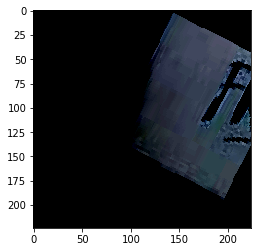

In [15]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
# protest = first[1][0]
violence = first[1][0]
visual = first[1][1]
img = np.array(image)
plt.imshow(img)
print("violence has shape", violence.shape, " visual has shape", visual.shape)

Select training and validation sets

### Modeling

In [16]:
mask_value = -1; lr = 0.01; momentum = 0.9; epochs = 100; patience = 10

In [17]:
hyper_params_name = "momentum-{}_batch_size-{}_n_folds-{}_n_folds_seed-{}".format(momentum, batch_size, n_folds,seed)
hyper_params_name

'momentum-0.9_batch_size-32_n_folds-5_n_folds_seed-300'

In [20]:
# COMMENT THIS OUT FOR RUN WITH THE WHOLE DATA SET
# size_sample = 34
# validation_df = validation_df[:34]
# test_df = test_df[:34]
# train_df = train_df[:34]
# batch_size = 8
# epochs = 1
# patience = 0

In [21]:
train_generator = au.ResizeSequence(
    train_df,
    batch_size, 
    targets = ['violence', tag_cols],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalizeMinMax,
        transforms.lighting,
        transforms.normalizeStandardScore
    ]
)
validation_generator = au.ResizeSequence(
    validation_df,
    batch_size, 
    targets = ['violence', tag_cols],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

test_generator = au.ResizeSequence(
    test_df,
    batch_size, 
    targets = ['violence', tag_cols],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)



# Modeling start
Kbackend.clear_session()

img_input = Klayers.Input(shape=(224,224,3), name='img_input')

resnet_model = Kapplications.ResNet50(include_top=False, weights = 'imagenet') (img_input)

flatten = Klayers.Flatten()(resnet_model)

# protest_out = Klayers.Dense(1, activation='sigmoid', name='protest_out')(flatten)
violence_out = Klayers.Dense(1, activation='sigmoid', name='violence_out')(flatten)
visual_out = Klayers.Dense(10, activation='sigmoid', name='visual_out')(flatten)

model = Kmodels.Model(inputs= img_input, outputs=[violence_out, visual_out])

# optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
# Using the default parameters set by Keras, which has them because they're as presented
# in the paper.
optimizer = Koptimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
    loss={
        'visual_out': au.buildMaskedLoss(Klosses.binary_crossentropy, mask_value), 
        'violence_out': au.buildMaskedLoss(Klosses.mean_squared_error, mask_value)
    },
    loss_weights={ 
        'visual_out': 5, 
        'violence_out': 10 
    }
)
model.summary()

try:
    __file__ # Apparently, this is not defined in the notebook,
         # but it will be when we start running on the server
         # (So when things gets real)
except NameError:
    __file__ = "test"


name = au.getExperimentName(__file__, len(df), epochs, lr, hyper_params_name)
csv_results = "models_preds/%s.csv" % name
model_checkout_path = "models/%s.hdf5" % name
csv_logger_path = "logs/%s.csv" % name
tensor_board_folder = os.path.join("logs", name)

if not os.path.exists(tensor_board_folder):
    os.makedirs(tensor_board_folder)

if not os.path.exists(tensor_board_folder):
    os.makedirs("logs")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models")

if not os.path.exists(tensor_board_folder):
    os.makedirs("models_preds")

print("Writing model to: \t%s" % model_checkout_path)
print("Writing log to: \t%s\n" % csv_logger_path)



# callbacks
change_lr = Kcallbacks.LearningRateScheduler(
    au.lrUpdateUCLA, 
    verbose = True
)

checkpoint = Kcallbacks.ModelCheckpoint(
    model_checkout_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
)

earlystop = Kcallbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=patience,
    verbose=1, 
    mode='auto'
)

tensor_board = Kcallbacks.TensorBoard(
    log_dir=tensor_board_folder,
     histogram_freq=0,
     batch_size=batch_size, 
     write_graph=True,
     write_grads=False, 
     write_images=False, 
     embeddings_freq=0,
     embeddings_layer_names=None,
     embeddings_metadata=None
)

csv_logger = Kcallbacks.CSVLogger(
    csv_logger_path, 
    separator=',', 
    append=False
)

history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger, earlystop]
)


# Preds

#load the weights from the best model
model.load_weights(model_checkout_path)

preds = model.predict_generator(test_generator, verbose = 1)
preds_violence = preds[0][:len(test_df)] # avoid getting more than the needed
preds_visuals = preds[1][:len(test_df)] 
print("visual shape is ", preds_visuals.shape, " violence shape is ", preds_violence.shape)
# Creates a panda data frame with the results

test_fold_results = test_df.copy()
test_fold_results[tag_cols] = preds_visuals
test_fold_results["pred_violence"] = preds_violence

print("saving results")
test_fold_results.to_csv(csv_results)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                multiple             23587712    img_input[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________
violence_out (Dense)            (None, 1)            2049        flatten_1[0][0]                  
__________________________________________________________________________________________________
visual_out